In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import scipy.optimize as spo

DATA_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/PhdProjects/Complicor/Data/"

def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

408.5


[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


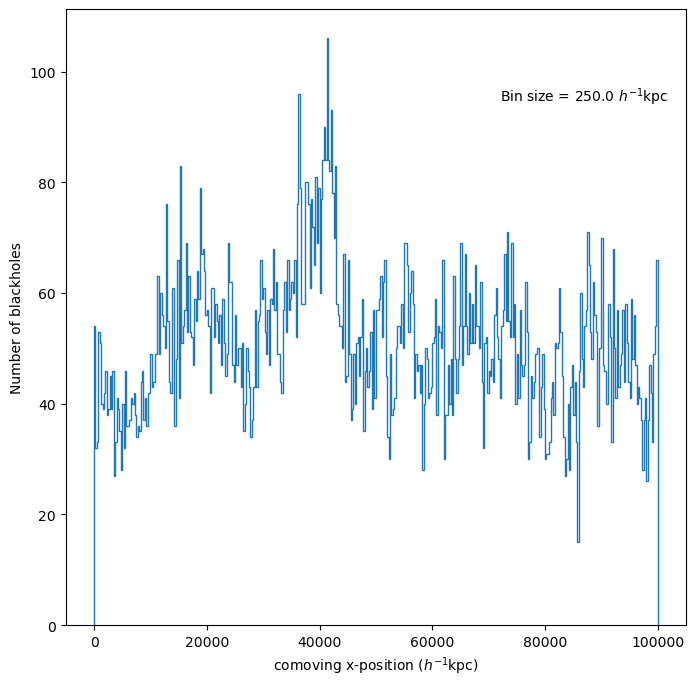

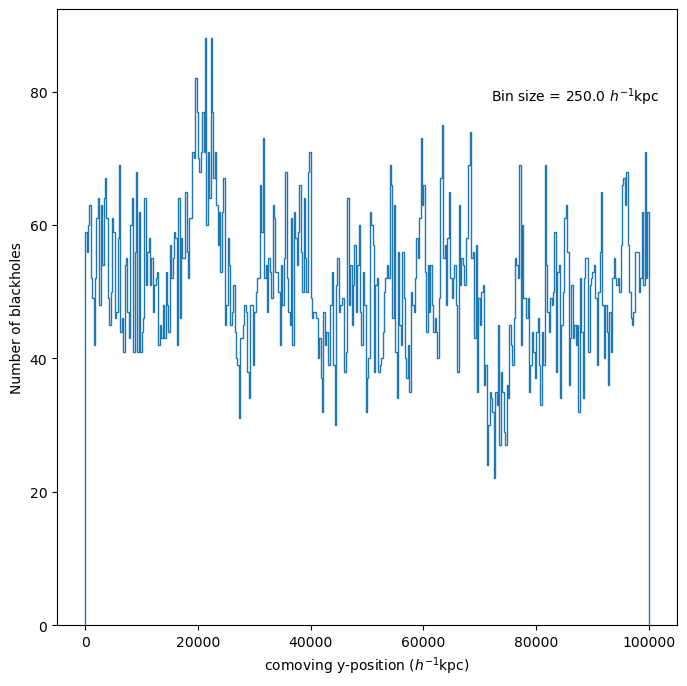

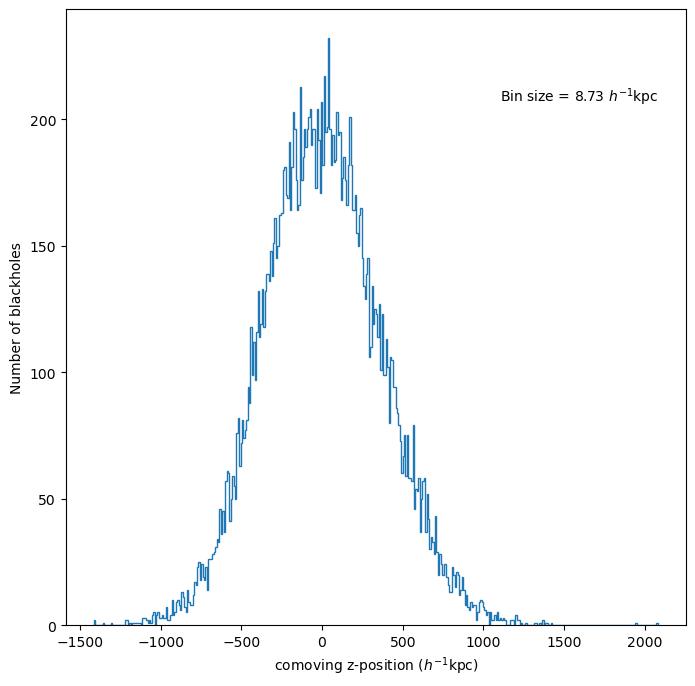

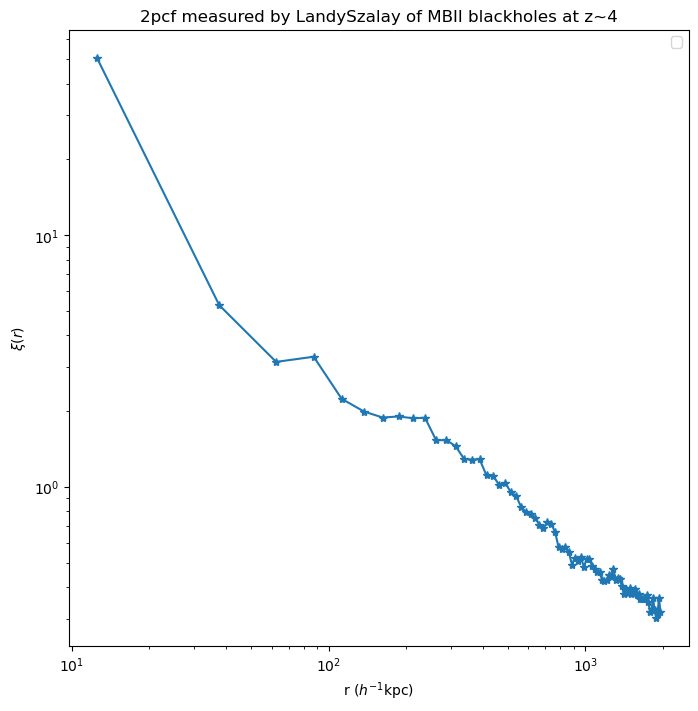

In [2]:
mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size = 25  ## Bin size used for correlation function measurement


MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(min_x, max_x, n_rand)
rand_y = np.random.uniform(min_y, max_y, n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((max_x - min_x)/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((max_y - min_y)/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

## ---------------------------------------------------------------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, bin_size)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))
ax.legend()

Text(0.5, 1.0, 'Blackhole distribution projected along z axis')

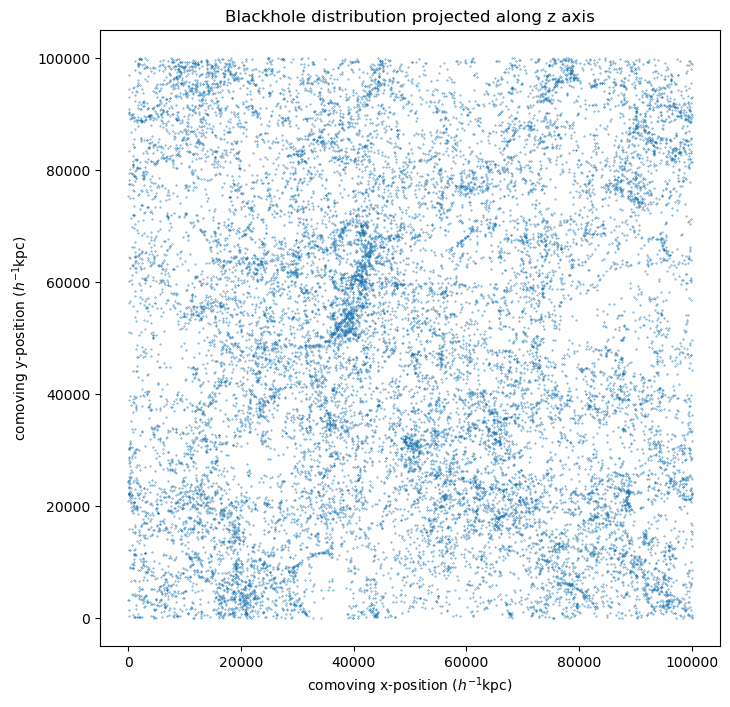

In [4]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bh_pos_x, bh_pos_y, s=0.1)
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'comoving y-position ($h^{-1}$kpc)')
ax.set_title('Blackhole distribution projected along z axis')

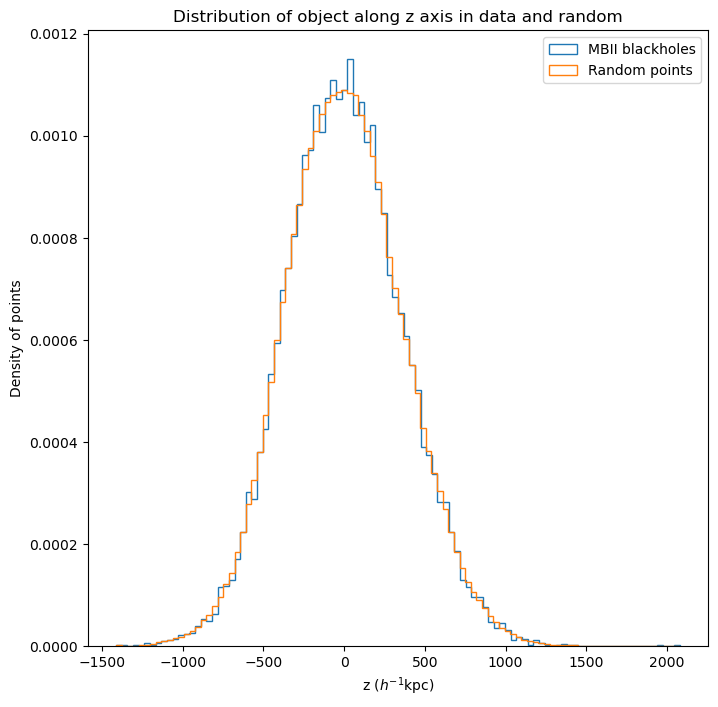

In [3]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(bh_pos_z, bins=100, histtype='step', density=True, label="MBII blackholes");
ax.hist(rand_z, bins=100, histtype='step', density=True, label="Random points");
ax.set_xlabel(r"z ($h^{-1}$kpc)")
ax.set_ylabel("Density of points")
ax.set_title("Distribution of object along z axis in data and random")
ax.legend()

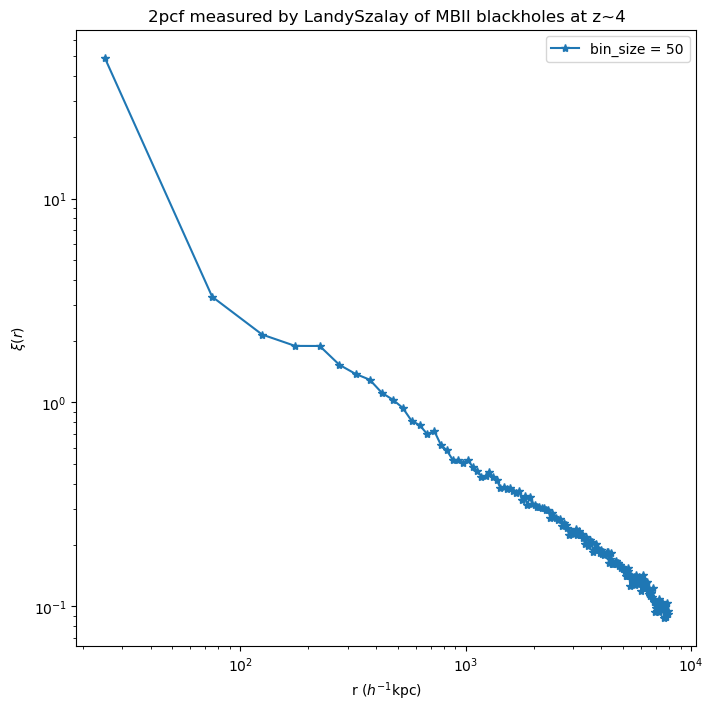

In [11]:
MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

fig, ax = plt.subplots(figsize = (8,8))

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    ax.plot(bin_mids, LandSzal2pcf, '-*', label="bin_size = {}".format(bin_size))

ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))
ax.legend()

In [14]:
for i in range(len(bin_mids)):
    print(LandSzal2pcf[i], "\n", end="")

49.149198676764414 
3.2983403332150014 
2.1516923872997697 
1.8930981347070635 
1.8916339907265387 
1.529503475513918 
1.3788551358237788 
1.292615552260988 
1.1135158848831523 
1.0313465792725287 
0.9415989284240807 
0.8131995873135295 
0.7734531794498474 
0.6992683480343882 
0.7254692698523075 
0.6209626522904165 
0.5811158449959408 
0.5237812998787836 
0.5201703205901659 
0.5044819551636766 
0.5194274335502255 
0.4829484908193303 
0.46074152788583506 
0.43270805802294166 
0.4346118733343622 
0.45501729094835835 
0.429370869805192 
0.41591693921449807 
0.38077246471765214 
0.38449397278940584 
0.37550263093041397 
0.3821525045961566 
0.3682244793873256 
0.35756584355484755 
0.3682136767318902 
0.3340580496172602 
0.34676707856153954 
0.3149691779045845 
0.34236106952609335 
0.3176502642096057 
0.3157122880842127 
0.3069734975037685 
0.3061809374451933 
0.30208889267906536 
0.304815184292267 
0.2977068803082169 
0.29555908371309697 
0.271355566935258 
0.28707983403656373 
0.2733508856

## Data at z ~ 5

160.72


/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(r, -alpha)
/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in multiply
  return A * np.power(r, -alpha)


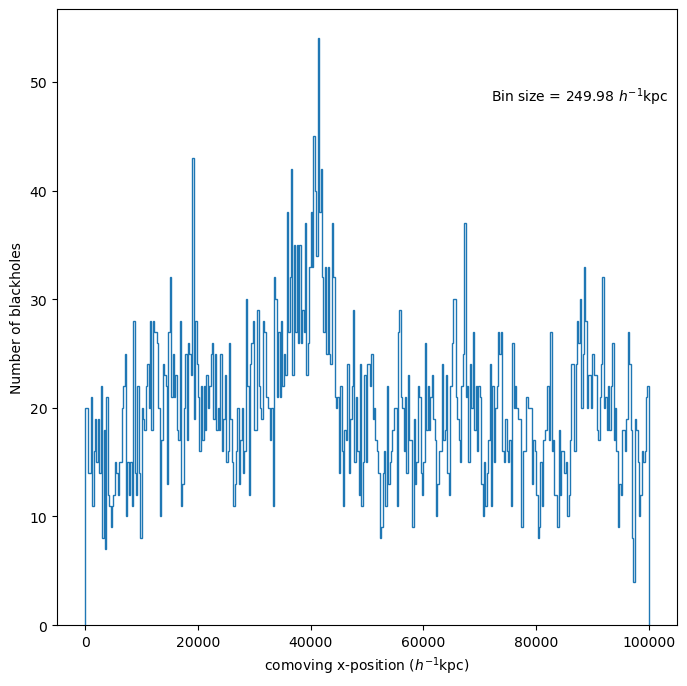

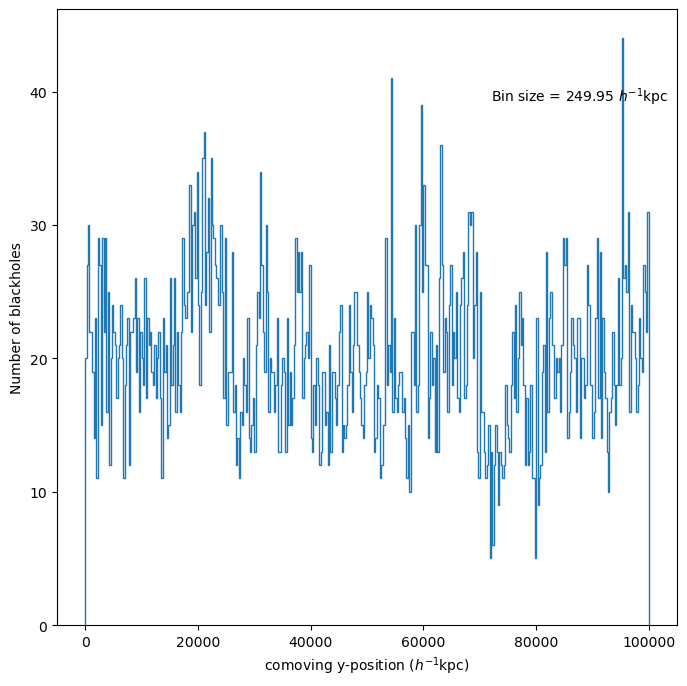

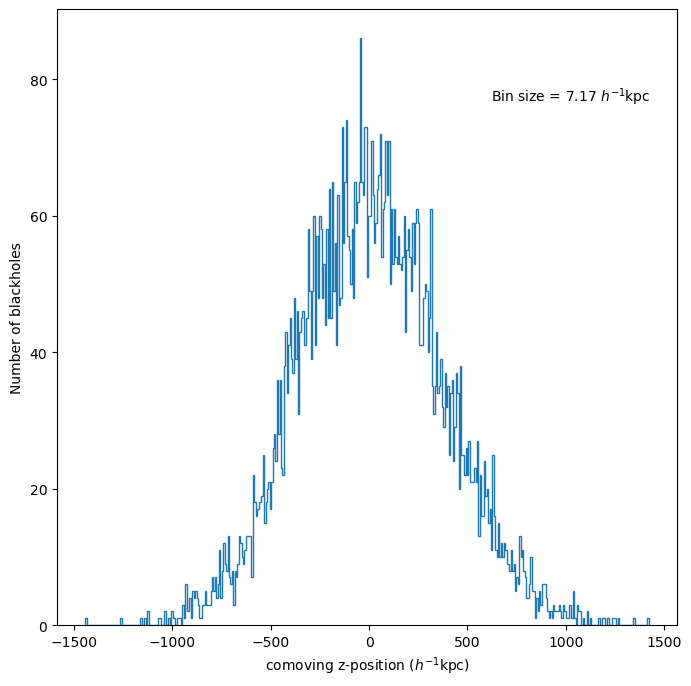

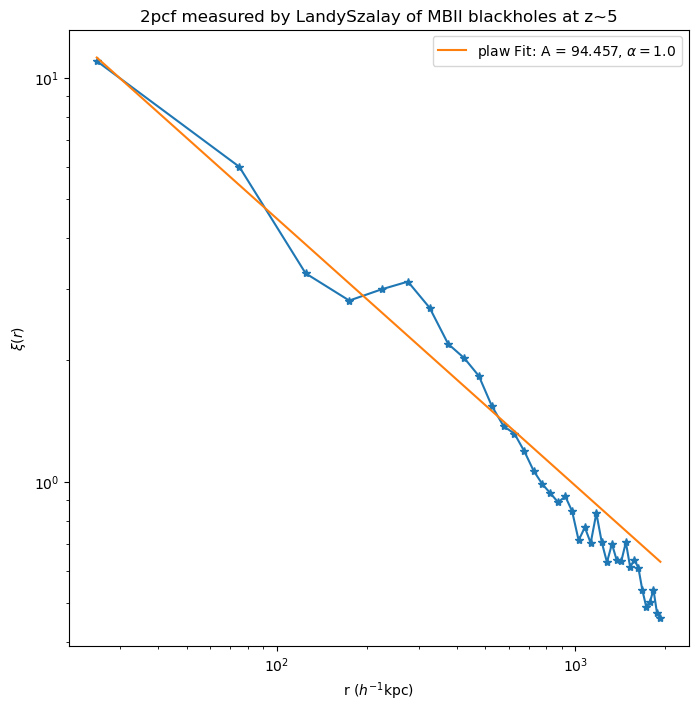

In [31]:
MBII_z5_filename = "bhprops_029.txt"
MBII_z5 = np.loadtxt(DATA_DIRECTORY + MBII_z5_filename)
redshift = 5

bh_pos_x = np.copy(MBII_z5[:, 2])
bh_pos_y = np.copy(MBII_z5[:, 3])
bh_pos_z = np.copy(MBII_z5[:, 4])
print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_x) - np.min(bh_pos_x))/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_y) - np.min(bh_pos_y))/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

mult = 10
n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(np.min(bh_pos_x), np.max(bh_pos_x), n_rand)
rand_y = np.random.uniform(np.min(bh_pos_y), np.max(bh_pos_y), n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals
z_bin_size = 5

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, 50)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~{}".format(redshift))
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha)))
ax.legend()

## Data at z ~ 6

55.42


/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(r, -alpha)
/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in multiply
  return A * np.power(r, -alpha)


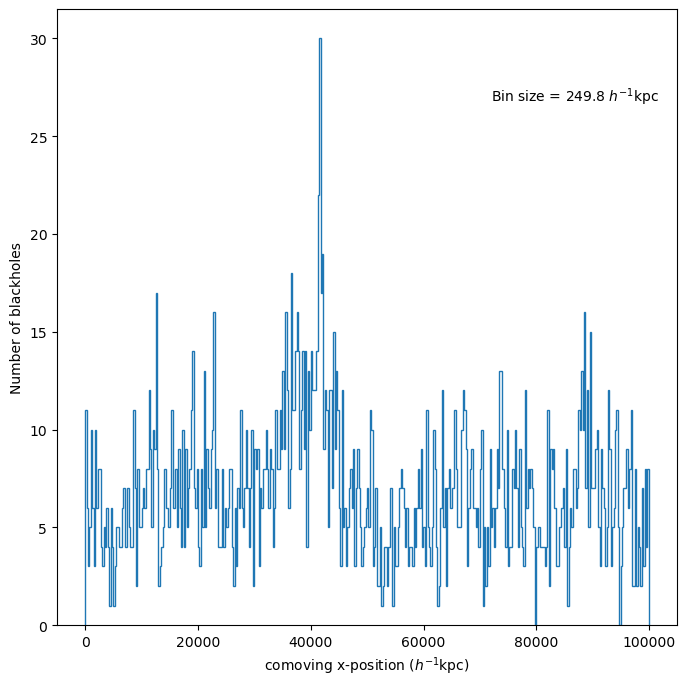

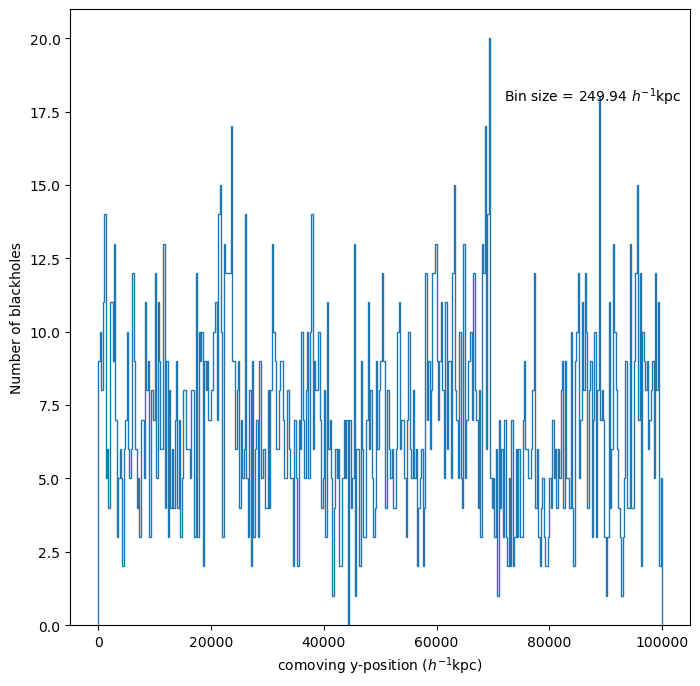

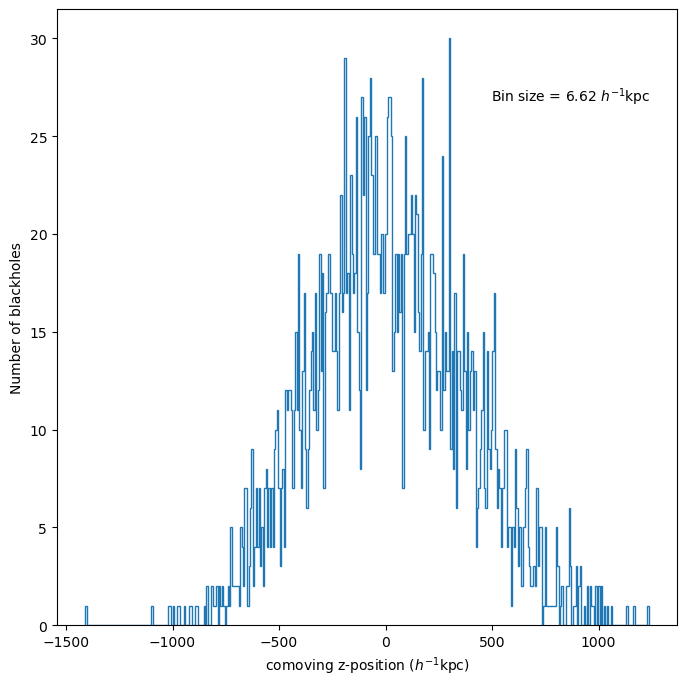

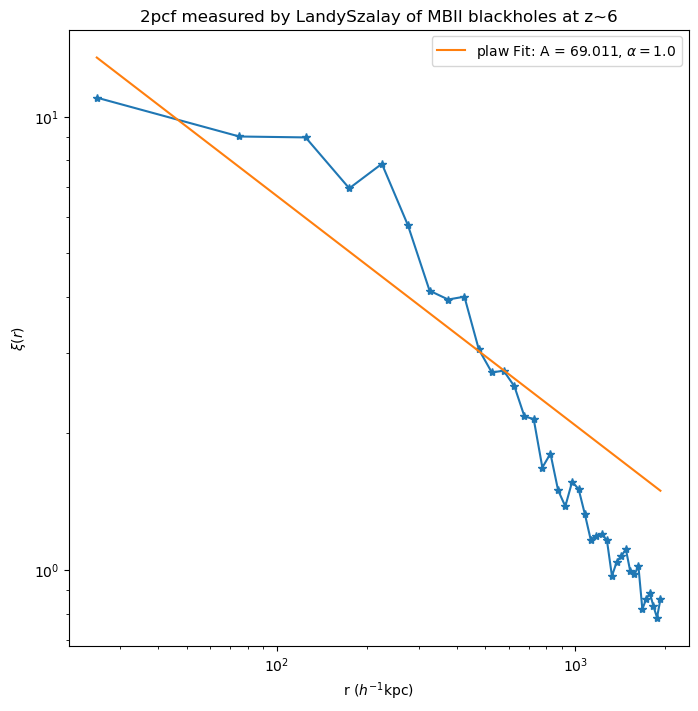

In [32]:
MBII_z6_filename = "bhprops_026.txt"
MBII_z6 = np.loadtxt(DATA_DIRECTORY + MBII_z6_filename)
redshift = 6

bh_pos_x = np.copy(MBII_z6[:, 2])
bh_pos_y = np.copy(MBII_z6[:, 3])
bh_pos_z = np.copy(MBII_z6[:, 4])
print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_x) - np.min(bh_pos_x))/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_y) - np.min(bh_pos_y))/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

mult = 10
n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(np.min(bh_pos_x), np.max(bh_pos_x), n_rand)
rand_y = np.random.uniform(np.min(bh_pos_y), np.max(bh_pos_y), n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals
z_bin_size = 5

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, 50)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~{}".format(redshift))
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha)))
ax.legend()

## Data at z ~ 7

24.44


/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(r, -alpha)


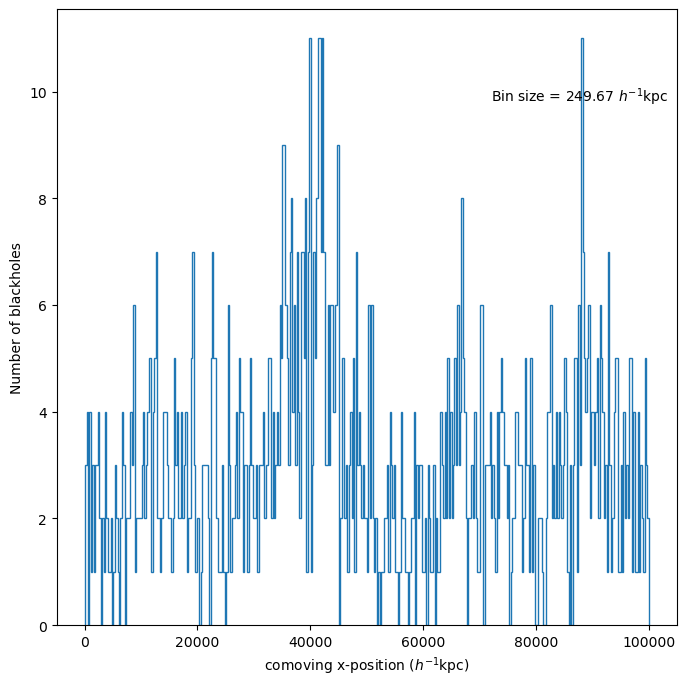

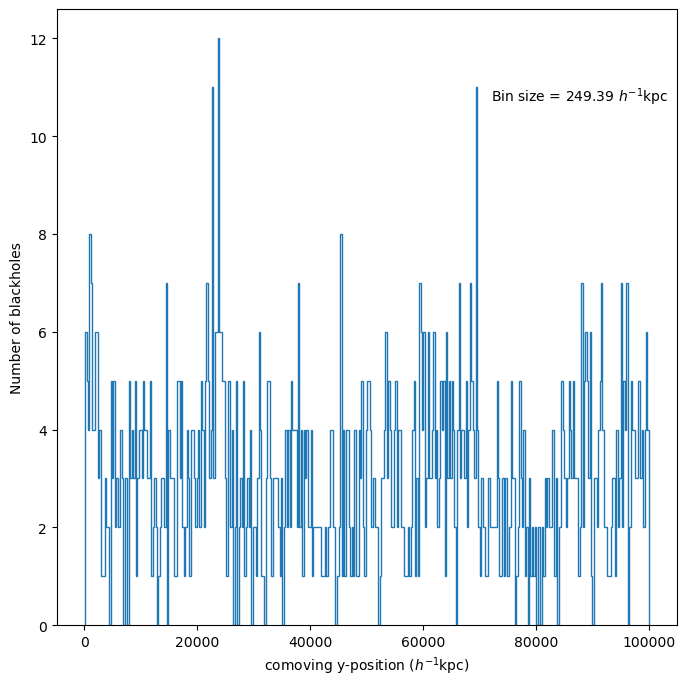

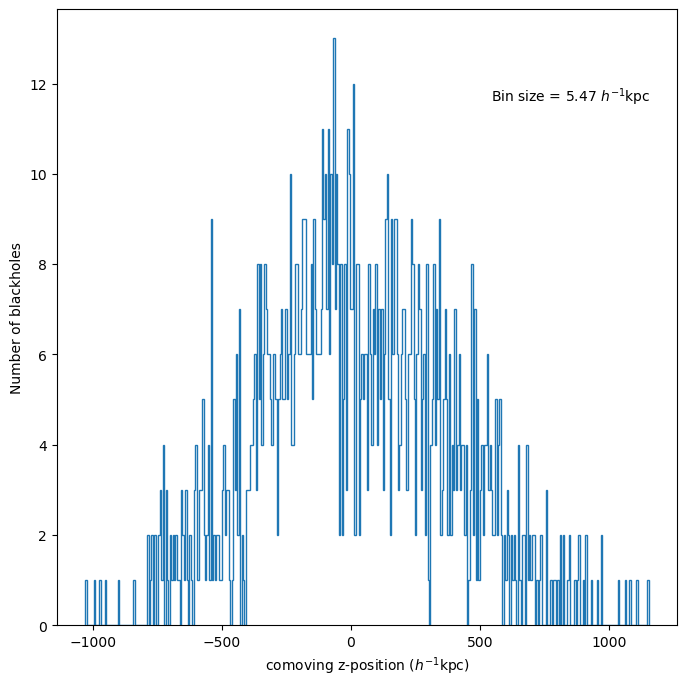

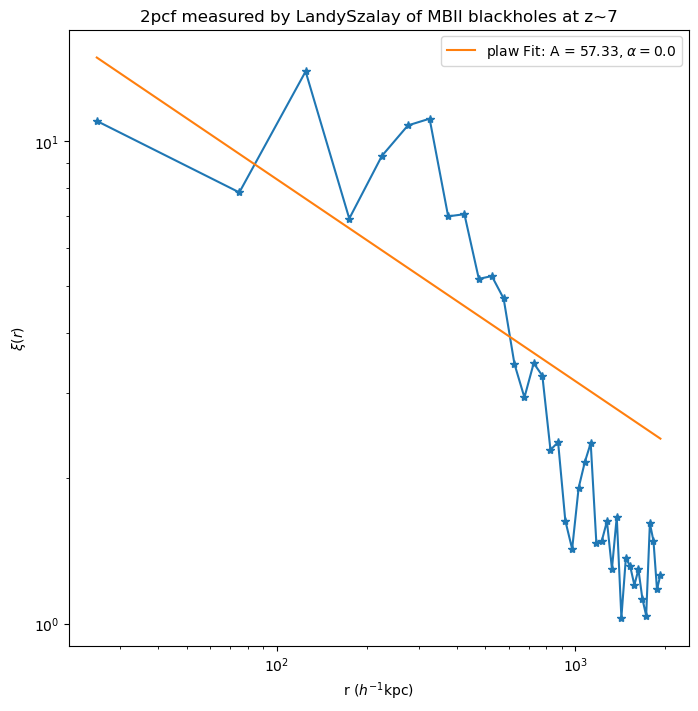

In [33]:
MBII_z6_filename = "bhprops_024.txt"
MBII_z6 = np.loadtxt(DATA_DIRECTORY + MBII_z6_filename)
redshift = 7

bh_pos_x = np.copy(MBII_z6[:, 2])
bh_pos_y = np.copy(MBII_z6[:, 3])
bh_pos_z = np.copy(MBII_z6[:, 4])
print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_x) - np.min(bh_pos_x))/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_y) - np.min(bh_pos_y))/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

mult = 10
n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(np.min(bh_pos_x), np.max(bh_pos_x), n_rand)
rand_y = np.random.uniform(np.min(bh_pos_y), np.max(bh_pos_y), n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals
z_bin_size = 5

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, 50)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~{}".format(redshift))
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha)))
ax.legend()